# 0. Preparación del Dataset: Austin Animal Center

**Objetivo:**  
Combinar los datasets de Intakes (entradas) y Outcomes (salidas) para crear un dataset final con la variable objetivo `TimeInShelterDays` (días en el refugio hasta ser adoptado).

**Datasets originales:**
- `Austin_Animal_Center_Intakes.csv` → Información al entrar al refugio
- `Austin_Animal_Center_Outcomes.csv` → Información al salir del refugio

**Proceso:**
1. Cargar ambos datasets
2. Cruzar por `Animal ID`
3. Filtrar solo adopciones (`Outcome Type == 'Adoption'`)
4. Calcular `TimeInShelterDays = Outcome DateTime - Intake DateTime`
5. Limpiar y preparar variables predictoras
6. Guardar dataset final

---

In [1]:
# ============================================
# Importaciones
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuración
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 0.1 Carga de Datasets Originales

Cargamos los dos datasets y verificamos su estructura.

---

In [2]:
# ============================================
# Cargar Datasets
# ============================================

# Cambiar la ruta según donde tengas los archivos
intakes = pd.read_csv('../data/Austin_Animal_Center_Intakes.csv')
outcomes = pd.read_csv('../data/Austin_Animal_Center_Outcomes.csv')

print("="*70)
print("DATASETS CARGADOS")
print("="*70)

print(f"\n📊 INTAKES (entradas al refugio):")
print(f"   Registros: {len(intakes):,}")
print(f"   Columnas: {intakes.shape[1]}")

print(f"\n📊 OUTCOMES (salidas del refugio):")
print(f"   Registros: {len(outcomes):,}")
print(f"   Columnas: {outcomes.shape[1]}")

print(f"\n📋 Columnas de INTAKES:")
print(list(intakes.columns))

print(f"\n📋 Columnas de OUTCOMES:")
print(list(outcomes.columns))

DATASETS CARGADOS

📊 INTAKES (entradas al refugio):
   Registros: 124,120
   Columnas: 12

📊 OUTCOMES (salidas del refugio):
   Registros: 124,491
   Columnas: 12

📋 Columnas de INTAKES:
['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Found Location', 'Intake Type', 'Intake Condition', 'Animal Type', 'Sex upon Intake', 'Age upon Intake', 'Breed', 'Color']

📋 Columnas de OUTCOMES:
['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Date of Birth', 'Outcome Type', 'Outcome Subtype', 'Animal Type', 'Sex upon Outcome', 'Age upon Outcome', 'Breed', 'Color']


## 0.2 Filtrar Solo Adopciones

**Decisión:** Solo nos interesan los animales que fueron **adoptados**.  
Filtramos `Outcome Type == 'Adoption'` antes de combinar.

---

In [3]:
# ============================================
# Filtrar Solo Adopciones
# ============================================

print("="*70)
print("TIPOS DE OUTCOME (antes de filtrar)")
print("="*70)
print(outcomes['Outcome Type'].value_counts())

# Filtrar solo adopciones
outcomes_adopted = outcomes[outcomes['Outcome Type'] == 'Adoption'].copy()

print(f"\n📊 DESPUÉS DEL FILTRO:")
print(f"   Outcomes totales: {len(outcomes):,}")
print(f"   Solo adopciones:  {len(outcomes_adopted):,}")
print(f"   Porcentaje:       {len(outcomes_adopted)/len(outcomes)*100:.1f}%")

TIPOS DE OUTCOME (antes de filtrar)
Outcome Type
Adoption           55347
Transfer           36713
Return to Owner    21517
Euthanasia          8381
Died                1156
Rto-Adopt            698
Disposal             568
Missing               69
Relocate              22
Name: count, dtype: int64

📊 DESPUÉS DEL FILTRO:
   Outcomes totales: 124,491
   Solo adopciones:  55,347
   Porcentaje:       44.5%


## 0.3 Combinar Intakes + Outcomes

**Método:** `INNER JOIN` por `Animal ID`  
Solo conservamos los animales que tienen **ambas** entradas (intake y outcome).

---

In [4]:
# ============================================
# Combinar por Animal ID
# ============================================

# Renombrar columnas para evitar conflictos al combinar
intakes_renamed = intakes.rename(columns={
    'DateTime': 'Intake_DateTime',
    'MonthYear': 'Intake_MonthYear',
    'Name': 'Name_Intake'
})

outcomes_renamed = outcomes_adopted.rename(columns={
    'DateTime': 'Outcome_DateTime',
    'MonthYear': 'Outcome_MonthYear',
    'Date of Birth': 'Date_of_Birth',
    'Name': 'Name_Outcome'
})

# Combinar (INNER JOIN)
df_combined = intakes_renamed.merge(
    outcomes_renamed,
    on='Animal ID',
    how='inner',
    suffixes=('_intake', '_outcome')
)

print("="*70)
print("COMBINACIÓN COMPLETADA")
print("="*70)
print(f"\n📊 Dataset combinado:")
print(f"   Registros: {len(df_combined):,}")
print(f"   Columnas:  {df_combined.shape[1]}")

print(f"\n📋 Muestra de columnas importantes:")
print(df_combined[['Animal ID', 'Intake_DateTime', 'Outcome_DateTime', 
                   'Animal Type_intake', 'Breed_intake']].head())

COMBINACIÓN COMPLETADA

📊 Dataset combinado:
   Registros: 72,403
   Columnas:  23

📋 Muestra de columnas importantes:
  Animal ID         Intake_DateTime        Outcome_DateTime  \
0   A818975  06/18/2020 02:53:00 PM  07/23/2020 03:54:00 PM   
1   A731435  08/08/2016 05:52:00 PM  07/29/2016 07:00:00 PM   
2   A760053  10/11/2017 03:46:00 PM  10/15/2017 06:30:00 PM   
3   A707375  07/11/2015 06:19:00 PM  11/28/2015 05:31:00 PM   
4   A696408  02/04/2015 12:58:00 PM  05/28/2015 11:24:00 AM   

  Animal Type_intake            Breed_intake  
0                Cat      Domestic Shorthair  
1                Cat  Domestic Shorthair Mix  
2                Dog     Chihuahua Shorthair  
3                Dog                Pit Bull  
4                Dog     Chihuahua Shorthair  


## 0.4 Calcular TimeInShelterDays (Variable Objetivo)

**Fórmula:**  
`TimeInShelterDays = (Outcome_DateTime - Intake_DateTime).days`

**Validaciones:**
- Eliminar registros con días negativos (error de datos)
- Eliminar registros con días = 0 (mismo día, probablemente error)
- Revisar outliers extremos (>365 días = 1 año)

---

C:\Users\zulay\AppData\Local\Temp\ipykernel_6516\1846426341.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_combined['Intake_DateTime'] = pd.to_datetime(df_combined['Intake_DateTime'])
C:\Users\zulay\AppData\Local\Temp\ipykernel_6516\1846426341.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_combined['Outcome_DateTime'] = pd.to_datetime(df_combined['Outcome_DateTime'])


VARIABLE OBJETIVO CREADA: TimeInShelterDays

📊 ESTADÍSTICAS:
count    72403.000000
mean        26.258056
std        222.526128
min      -2411.000000
25%          4.000000
50%         10.000000
75%         45.000000
max       2522.000000
Name: TimeInShelterDays, dtype: float64

⚠️  VALORES PROBLEMÁTICOS:
   Días negativos: 9464
   Días = 0:       818
   Días > 365:     2202


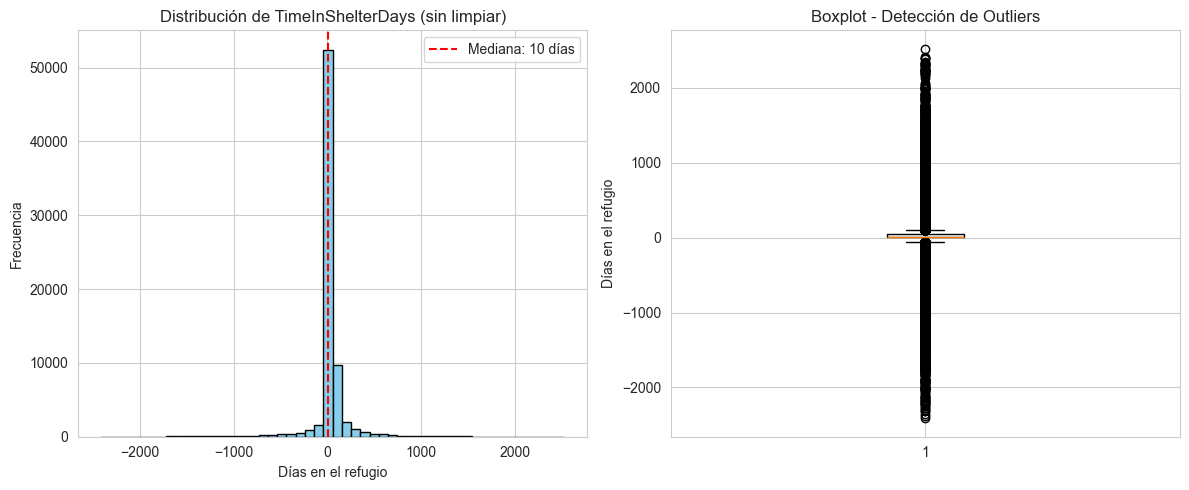

In [5]:
# ============================================
# Calcular TimeInShelterDays
# ============================================

# Convertir a datetime
df_combined['Intake_DateTime'] = pd.to_datetime(df_combined['Intake_DateTime'])
df_combined['Outcome_DateTime'] = pd.to_datetime(df_combined['Outcome_DateTime'])

# Calcular diferencia en días
df_combined['TimeInShelterDays'] = (
    df_combined['Outcome_DateTime'] - df_combined['Intake_DateTime']
).dt.days

print("="*70)
print("VARIABLE OBJETIVO CREADA: TimeInShelterDays")
print("="*70)

print(f"\n📊 ESTADÍSTICAS:")
print(df_combined['TimeInShelterDays'].describe())

print(f"\n⚠️  VALORES PROBLEMÁTICOS:")
print(f"   Días negativos: {(df_combined['TimeInShelterDays'] < 0).sum()}")
print(f"   Días = 0:       {(df_combined['TimeInShelterDays'] == 0).sum()}")
print(f"   Días > 365:     {(df_combined['TimeInShelterDays'] > 365).sum()}")

# Visualizar distribución
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_combined['TimeInShelterDays'], bins=50, edgecolor='black', color='skyblue')
plt.xlabel('Días en el refugio')
plt.ylabel('Frecuencia')
plt.title('Distribución de TimeInShelterDays (sin limpiar)')
plt.axvline(df_combined['TimeInShelterDays'].median(), color='red', 
            linestyle='--', label=f'Mediana: {df_combined["TimeInShelterDays"].median():.0f} días')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df_combined['TimeInShelterDays'])
plt.ylabel('Días en el refugio')
plt.title('Boxplot - Detección de Outliers')

plt.tight_layout()
plt.show()

### Interpretación

**Antes de limpiar:**
- Media: [COMPLETAR] días
- Mediana: [COMPLETAR] días
- Mínimo: [COMPLETAR] días
- Máximo: [COMPLETAR] días

**Decisiones de limpieza:**
- ❌ Eliminar días < 0 (errores de datos)
- ❌ Eliminar días = 0 (adopciones el mismo día, probablemente errores)
- ⚠️ Revisar días > 365 (casos extremos pero posibles)

---

LIMPIEZA DE TimeInShelterDays

Registros ANTES de limpiar: 72,403
Registros DESPUÉS de limpiar: 59,919
Eliminados: 12,484 (17.2%)

📊 ESTADÍSTICAS DESPUÉS DE LIMPIAR:
count    59919.000000
mean        38.523423
std         57.175649
min          1.000000
25%          5.000000
50%         15.000000
75%         48.000000
max        365.000000
Name: TimeInShelterDays, dtype: float64


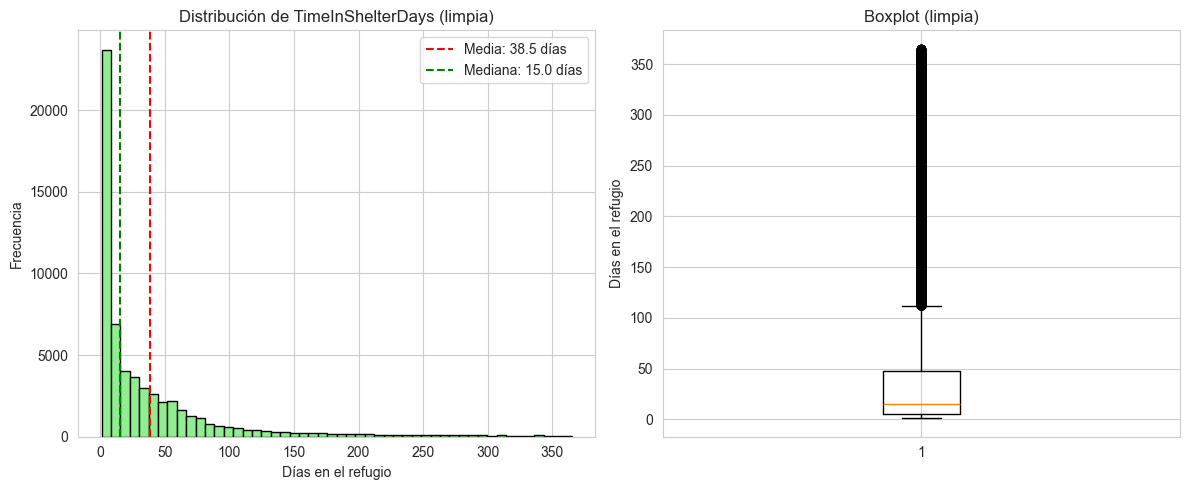

In [6]:
# ============================================
# Limpiar Variable Objetivo
# ============================================

print("="*70)
print("LIMPIEZA DE TimeInShelterDays")
print("="*70)

print(f"\nRegistros ANTES de limpiar: {len(df_combined):,}")

# Filtrar solo días válidos (> 0 y <= 365)
df_clean = df_combined[
    (df_combined['TimeInShelterDays'] > 0) & 
    (df_combined['TimeInShelterDays'] <= 365)
].copy()

print(f"Registros DESPUÉS de limpiar: {len(df_clean):,}")
print(f"Eliminados: {len(df_combined) - len(df_clean):,} ({(len(df_combined) - len(df_clean))/len(df_combined)*100:.1f}%)")

print(f"\n📊 ESTADÍSTICAS DESPUÉS DE LIMPIAR:")
print(df_clean['TimeInShelterDays'].describe())

# Visualizar distribución limpia
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_clean['TimeInShelterDays'], bins=50, edgecolor='black', color='lightgreen')
plt.xlabel('Días en el refugio')
plt.ylabel('Frecuencia')
plt.title('Distribución de TimeInShelterDays (limpia)')
plt.axvline(df_clean['TimeInShelterDays'].mean(), color='red', 
            linestyle='--', label=f'Media: {df_clean["TimeInShelterDays"].mean():.1f} días')
plt.axvline(df_clean['TimeInShelterDays'].median(), color='green', 
            linestyle='--', label=f'Mediana: {df_clean["TimeInShelterDays"].median():.1f} días')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df_clean['TimeInShelterDays'])
plt.ylabel('Días en el refugio')
plt.title('Boxplot (limpia)')

plt.tight_layout()
plt.show()

## 0.5 Seleccionar y Limpiar Variables Predictoras

**Variables a usar (del INTAKE - info disponible al entrar):**

| Variable | Tipo | Descripción |
|----------|------|-------------|
| Animal Type | Categórica | Dog/Cat/Other |
| Breed | Categórica | Raza del animal |
| Color | Categórica | Color |
| Sex upon Intake | Categórica | Macho/Hembra + Esterilizado |
| Age upon Intake | Numérica | Edad al entrar (convertir a días) |
| Intake Type | Categórica | Stray/Owner Surrender/Public Assist |
| Intake Condition | Categórica | Normal/Sick/Injured |

**Variables a eliminar:**
- Animal ID (identificador)
- Name (no aporta info)
- DateTime, MonthYear (ya usadas para calcular Y)
- Found Location (demasiadas categorías únicas)
- Todas las columnas de OUTCOME (info del futuro)

---

In [7]:
# ============================================
# Seleccionar Columnas Relevantes
# ============================================

# Columnas a conservar
columns_to_keep = [
    # Variables predictoras (del INTAKE)
    'Animal Type_intake',
    'Breed_intake',
    'Color_intake',
    'Sex upon Intake',
    'Age upon Intake',
    'Intake Type',
    'Intake Condition',
    # Variable objetivo
    'TimeInShelterDays'
]

df_final = df_clean[columns_to_keep].copy()

# Renombrar para simplicidad
df_final = df_final.rename(columns={
    'Animal Type_intake': 'AnimalType',
    'Breed_intake': 'Breed',
    'Color_intake': 'Color',
    'Sex upon Intake': 'Sex',
    'Age upon Intake': 'AgeUponIntake',
    'Intake Type': 'IntakeType',
    'Intake Condition': 'IntakeCondition'
})

print("="*70)
print("DATASET FINAL CREADO")
print("="*70)
print(f"\nDimensiones: {df_final.shape[0]:,} filas x {df_final.shape[1]} columnas")
print(f"\nColumnas: {list(df_final.columns)}")
print(f"\n📊 Primeras filas:")
print(df_final.head())

print(f"\n📊 Tipos de datos:")
print(df_final.dtypes)

print(f"\n📊 Valores nulos:")
print(df_final.isnull().sum())

DATASET FINAL CREADO

Dimensiones: 59,919 filas x 8 columnas

Columnas: ['AnimalType', 'Breed', 'Color', 'Sex', 'AgeUponIntake', 'IntakeType', 'IntakeCondition', 'TimeInShelterDays']

📊 Primeras filas:
  AnimalType                   Breed              Color            Sex  \
0        Cat      Domestic Shorthair        Cream Tabby    Intact Male   
2        Dog     Chihuahua Shorthair          White/Tan    Intact Male   
3        Dog                Pit Bull        Brown/White  Intact Female   
4        Dog     Chihuahua Shorthair           Tricolor  Intact Female   
5        Cat  Domestic Shorthair Mix  Brown Tabby/White  Neutered Male   

  AgeUponIntake       IntakeType IntakeCondition  TimeInShelterDays  
0       4 weeks            Stray          Normal                 35  
2       2 years            Stray          Normal                  4  
3      5 months            Stray          Normal                139  
4       2 years            Stray          Normal                112  
5  

## 0.6 Convertir Age upon Intake a Días

La columna `AgeUponIntake` está en formato texto: `"2 years"`, `"4 months"`, `"3 weeks"`, `"5 days"`.  
Necesitamos convertirla a **días** (numérica).

**Conversiones:**
- 1 year = 365 días
- 1 month = 30 días
- 1 week = 7 días

---

In [8]:
# ============================================
# Convertir Age upon Intake a Días
# ============================================

def age_to_days(age_str):
    """
    Convierte edad en formato texto a días.
    Ejemplos: '2 years' → 730, '4 months' → 120, '3 weeks' → 21
    """
    if pd.isna(age_str):
        return np.nan
    
    age_str = str(age_str).lower()
    
    try:
        # Extraer número
        parts = age_str.split()
        number = int(parts[0])
        unit = parts[1]
        
        # Convertir según la unidad
        if 'year' in unit:
            return number * 365
        elif 'month' in unit:
            return number * 30
        elif 'week' in unit:
            return number * 7
        elif 'day' in unit:
            return number
        else:
            return np.nan
    except:
        return np.nan

# Aplicar conversión
df_final['AgeInDays'] = df_final['AgeUponIntake'].apply(age_to_days)

print("="*70)
print("CONVERSIÓN DE EDAD A DÍAS")
print("="*70)

print(f"\n📋 Ejemplos de conversión:")
print(df_final[['AgeUponIntake', 'AgeInDays']].head(10))

print(f"\n📊 Estadísticas de AgeInDays:")
print(df_final['AgeInDays'].describe())

print(f"\n⚠️ Valores nulos después de conversión:")
print(f"   AgeInDays nulos: {df_final['AgeInDays'].isnull().sum()} ({df_final['AgeInDays'].isnull().sum()/len(df_final)*100:.2f}%)")

# Eliminar la columna original en texto
df_final = df_final.drop(columns=['AgeUponIntake'])

CONVERSIÓN DE EDAD A DÍAS

📋 Ejemplos de conversión:
   AgeUponIntake  AgeInDays
0        4 weeks         28
2        2 years        730
3       5 months        150
4        2 years        730
5       14 years       5110
7        1 month         30
8        4 weeks         28
9        1 month         30
10      2 months         60
13       2 years        730

📊 Estadísticas de AgeInDays:
count    59919.000000
mean       591.289374
std        868.293755
min          0.000000
25%         60.000000
50%        300.000000
75%        730.000000
max       6935.000000
Name: AgeInDays, dtype: float64

⚠️ Valores nulos después de conversión:
   AgeInDays nulos: 0 (0.00%)


## 0.7 Manejo de Valores Nulos

Revisamos y tratamos los valores nulos finales.

---

In [9]:
# ============================================
# Análisis de Valores Nulos
# ============================================

print("="*70)
print("VALORES NULOS FINALES")
print("="*70)

null_counts = df_final.isnull().sum()
null_pcts = (null_counts / len(df_final)) * 100

null_df = pd.DataFrame({
    'Nulos': null_counts,
    'Porcentaje': null_pcts
})

print(null_df[null_df['Nulos'] > 0])

# Decisión: Eliminar filas con nulos en AgeInDays (si son pocos)
if df_final['AgeInDays'].isnull().sum() / len(df_final) < 0.05:  # < 5%
    print(f"\n✅ Eliminando {df_final['AgeInDays'].isnull().sum()} filas con AgeInDays nulo (< 5%)")
    df_final = df_final.dropna(subset=['AgeInDays'])
else:
    print(f"\n⚠️ {df_final['AgeInDays'].isnull().sum()} filas con AgeInDays nulo (> 5%)")
    print("   Se imputará con la mediana en el preprocesamiento")

print(f"\n📊 Dimensiones finales: {df_final.shape[0]:,} filas x {df_final.shape[1]} columnas")

VALORES NULOS FINALES
Empty DataFrame
Columns: [Nulos, Porcentaje]
Index: []

✅ Eliminando 0 filas con AgeInDays nulo (< 5%)

📊 Dimensiones finales: 59,919 filas x 8 columnas


## 0.8 Guardar Dataset Final

Guardamos el dataset limpio y listo para el EDA.

---

In [10]:
# ============================================
# Guardar Dataset Final
# ============================================

output_path = '../data/pet_adoption_clean.csv'
df_final.to_csv(output_path, index=False)

print("="*70)
print("DATASET GUARDADO")
print("="*70)
print(f"\n✅ Archivo: {output_path}")
print(f"✅ Registros: {len(df_final):,}")
print(f"✅ Columnas: {df_final.shape[1]}")

print(f"\n📋 Resumen del dataset final:")
print(f"\n{df_final.info()}")

print(f"\n📊 Estadísticas de la variable objetivo:")
print(df_final['TimeInShelterDays'].describe())

DATASET GUARDADO

✅ Archivo: ../data/pet_adoption_clean.csv
✅ Registros: 59,919
✅ Columnas: 8

📋 Resumen del dataset final:
<class 'pandas.core.frame.DataFrame'>
Index: 59919 entries, 0 to 72402
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   AnimalType         59919 non-null  object
 1   Breed              59919 non-null  object
 2   Color              59919 non-null  object
 3   Sex                59919 non-null  object
 4   IntakeType         59919 non-null  object
 5   IntakeCondition    59919 non-null  object
 6   TimeInShelterDays  59919 non-null  int64 
 7   AgeInDays          59919 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 4.1+ MB

None

📊 Estadísticas de la variable objetivo:
count    59919.000000
mean        38.523423
std         57.175649
min          1.000000
25%          5.000000
50%         15.000000
75%         48.000000
max        365.000000
Name: TimeInShelterDays, dtype

## 📊 Resumen Final

**Dataset creado exitosamente:**

| Concepto | Valor |
|----------|-------|
| **Registros totales** | [COMPLETAR] |
| **Variable objetivo** | TimeInShelterDays (días en refugio) |
| **Rango de Y** | [MIN] - [MAX] días |
| **Media de Y** | [MEDIA] días |
| **Mediana de Y** | [MEDIANA] días |
| **Variables predictoras** | 7 |
| **Categóricas** | AnimalType, Breed, Color, Sex, IntakeType, IntakeCondition |
| **Numéricas** | AgeInDays |

**Próximo paso:**
- EDA completo del dataset limpio
- Análisis univariante de TimeInShelterDays
- Análisis bivariante de correlaciones

---

ANÁLISIS DE AgeInDays

📊 Estadísticas de edad:
count    59919.000000
mean       591.289374
std        868.293755
min          0.000000
25%         60.000000
50%        300.000000
75%        730.000000
max       6935.000000
Name: AgeInDays, dtype: float64

⚠️  EDADES PROBLEMÁTICAS:
   Edad = 0 días:     304 (0.51%)
   Edad < 7 días:     1016 (1.70%)
   Edad < 14 días:    1445 (2.41%)


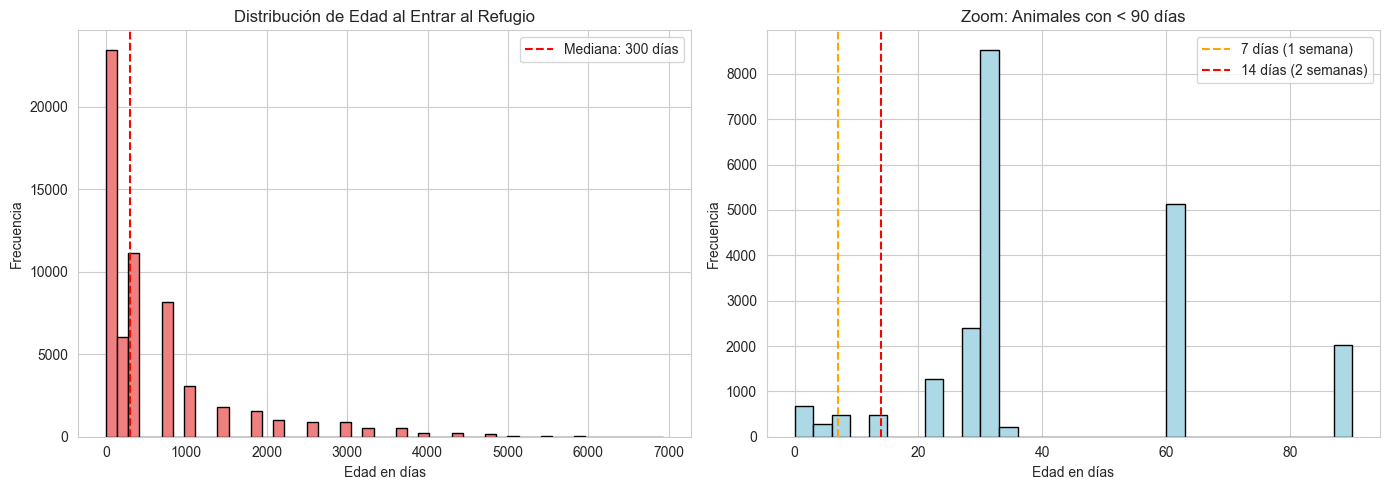


📋 EJEMPLOS DE ANIMALES MUY JÓVENES (< 7 días):
      AnimalType  AgeInDays       IntakeType IntakeCondition  \
70670        Dog          0            Stray         Nursing   
71205        Dog          0            Stray          Normal   
2570         Dog          0            Stray          Normal   
2571         Dog          0            Stray          Normal   
2572         Dog          0            Stray          Normal   
2696         Dog          0            Stray         Nursing   
3011         Dog          0  Owner Surrender         Nursing   
3025         Cat          0            Stray         Nursing   
3040         Dog          0            Stray          Normal   
3447         Dog          0            Stray          Normal   

       TimeInShelterDays  
70670                 63  
71205                 69  
2570                 361  
2571                 282  
2572                  60  
2696                  82  
3011                  75  
3025                 199  
3040

In [11]:
# ============================================
# Análisis de Edades Problemáticas
# ============================================

print("="*70)
print("ANÁLISIS DE AgeInDays")
print("="*70)

print(f"\n📊 Estadísticas de edad:")
print(df_final['AgeInDays'].describe())

print(f"\n⚠️  EDADES PROBLEMÁTICAS:")
print(f"   Edad = 0 días:     {(df_final['AgeInDays'] == 0).sum()} ({(df_final['AgeInDays'] == 0).sum()/len(df_final)*100:.2f}%)")
print(f"   Edad < 7 días:     {(df_final['AgeInDays'] < 7).sum()} ({(df_final['AgeInDays'] < 7).sum()/len(df_final)*100:.2f}%)")
print(f"   Edad < 14 días:    {(df_final['AgeInDays'] < 14).sum()} ({(df_final['AgeInDays'] < 14).sum()/len(df_final)*100:.2f}%)")

# Visualizar distribución de edades
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma completo
axes[0].hist(df_final['AgeInDays'], bins=50, edgecolor='black', color='lightcoral')
axes[0].set_xlabel('Edad en días')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Edad al Entrar al Refugio')
axes[0].axvline(df_final['AgeInDays'].median(), color='red', 
                linestyle='--', label=f'Mediana: {df_final["AgeInDays"].median():.0f} días')
axes[0].legend()

# Zoom en edades jóvenes (0-90 días)
young_animals = df_final[df_final['AgeInDays'] <= 90]
axes[1].hist(young_animals['AgeInDays'], bins=30, edgecolor='black', color='lightblue')
axes[1].set_xlabel('Edad en días')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Zoom: Animales con < 90 días')
axes[1].axvline(7, color='orange', linestyle='--', label='7 días (1 semana)')
axes[1].axvline(14, color='red', linestyle='--', label='14 días (2 semanas)')
axes[1].legend()

plt.tight_layout()
plt.show()

# Mostrar ejemplos de animales muy jóvenes
print(f"\n📋 EJEMPLOS DE ANIMALES MUY JÓVENES (< 7 días):")
very_young = df_final[df_final['AgeInDays'] < 7].sort_values('AgeInDays')
if len(very_young) > 0:
    print(very_young[['AnimalType', 'AgeInDays', 'IntakeType', 'IntakeCondition', 'TimeInShelterDays']].head(10))
else:
    print("   No hay animales con edad < 7 días")

In [12]:
# ============================================
# Decisión: Filtrar Edades Muy Jóvenes
# ============================================

print("="*70)
print("DECISIÓN SOBRE EDADES MUY JÓVENES")
print("="*70)

# Contar cuántos hay
zero_age = (df_final['AgeInDays'] == 0).sum()
very_young = (df_final['AgeInDays'] < 7).sum()

print(f"\nAnimales con 0 días: {zero_age}")
print(f"Animales con < 7 días (< 1 semana): {very_young}")

# Decisión basada en porcentaje
if very_young / len(df_final) < 0.01:  # < 1%
    print(f"\n✅ DECISIÓN: ELIMINAR animales con < 7 días")
    print(f"   Razón: Son solo {very_young/len(df_final)*100:.2f}% del dataset")
    print(f"   Justificación: Animales < 1 semana no son adoptables normalmente")
    
    df_final_filtered = df_final[df_final['AgeInDays'] >= 7].copy()
    
    print(f"\n📊 Registros ANTES: {len(df_final):,}")
    print(f"   Registros DESPUÉS: {len(df_final_filtered):,}")
    print(f"   Eliminados: {len(df_final) - len(df_final_filtered):,}")
    
    # Actualizar dataset
    df_final = df_final_filtered
    
else:
    print(f"\n⚠️  DECISIÓN: MANTENER todos (son {very_young/len(df_final)*100:.2f}% del dataset)")
    print(f"   Razón: Eliminaríamos demasiados registros")
    print(f"   Nota: El modelo aprenderá que animales muy jóvenes tienen patrones especiales")

print(f"\n✅ Dataset final: {len(df_final):,} registros")

DECISIÓN SOBRE EDADES MUY JÓVENES

Animales con 0 días: 304
Animales con < 7 días (< 1 semana): 1016

⚠️  DECISIÓN: MANTENER todos (son 1.70% del dataset)
   Razón: Eliminaríamos demasiados registros
   Nota: El modelo aprenderá que animales muy jóvenes tienen patrones especiales

✅ Dataset final: 59,919 registros


In [13]:
# ============================================
# Guardar Dataset Final (con filtro de edad)
# ============================================

output_path = '../data/pet_adoption_clean.csv'
df_final.to_csv(output_path, index=False)

print("="*70)
print("DATASET FINAL GUARDADO")
print("="*70)
print(f"\n✅ Archivo: {output_path}")
print(f"✅ Registros: {len(df_final):,}")

print(f"\n📊 RESUMEN FINAL:")
print(f"\n   Variable objetivo (TimeInShelterDays):")
print(f"   - Media:    {df_final['TimeInShelterDays'].mean():.2f} días")
print(f"   - Mediana:  {df_final['TimeInShelterDays'].median():.2f} días")
print(f"   - Std:      {df_final['TimeInShelterDays'].std():.2f} días")
print(f"   - Rango:    {df_final['TimeInShelterDays'].min():.0f} - {df_final['TimeInShelterDays'].max():.0f} días")

print(f"\n   Edad al entrar (AgeInDays):")
print(f"   - Media:    {df_final['AgeInDays'].mean():.2f} días ({df_final['AgeInDays'].mean()/365:.1f} años)")
print(f"   - Mediana:  {df_final['AgeInDays'].median():.2f} días ({df_final['AgeInDays'].median()/365:.1f} años)")
print(f"   - Rango:    {df_final['AgeInDays'].min():.0f} - {df_final['AgeInDays'].max():.0f} días")

print(f"\n✅ Dataset listo para EDA")

DATASET FINAL GUARDADO

✅ Archivo: ../data/pet_adoption_clean.csv
✅ Registros: 59,919

📊 RESUMEN FINAL:

   Variable objetivo (TimeInShelterDays):
   - Media:    38.52 días
   - Mediana:  15.00 días
   - Std:      57.18 días
   - Rango:    1 - 365 días

   Edad al entrar (AgeInDays):
   - Media:    591.29 días (1.6 años)
   - Mediana:  300.00 días (0.8 años)
   - Rango:    0 - 6935 días

✅ Dataset listo para EDA
